In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import os

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

import copy

from agentfil.filecoin_model import FilecoinModel, solve_geometric, distribute_agent_power_geometric_series
from agentfil.agents.dca_agent import DCAAgentTerminate
from agentfil import constants
from mechafil import minting, sim

import numpyro

In [3]:
NDEVICES=2
numpyro.set_host_device_count(NDEVICES)

simulation_start_date = date(2023, 6, 1)
forecast_length = 2*365
end_date = simulation_start_date + timedelta(days=forecast_length)

num_agents = 6
agent_power_distributions = distribute_agent_power_geometric_series(num_agents, a=0.35)
# agent_power_distributions = np.ones(num_agents)/float(num_agents)
print(agent_power_distributions)

auth_token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

print('Simulation Start:', simulation_start_date)

[0.35, 0.24034518566674812, 0.16504516649481035, 0.11333660338455585, 0.0778283056665705, 0.05344473878731517]
Simulation Start: 2023-06-01


In [4]:
data.setup_spacescope(auth_token)
# get historical data
historical_data_fp = '/tmp/abm/historical_data.pkl'
if not os.path.exists(historical_data_fp):
    historical_stats = data.get_historical_network_stats(
        constants.NETWORK_DATA_START,
        simulation_start_date,
        end_date
    )
    scheduled_df = data.query_sector_expirations(constants.NETWORK_DATA_START, end_date)
    os.makedirs('/tmp/abm',exist_ok=True)
    with open(historical_data_fp, 'wb') as f:
        pickle.dump({
            'historical_stats': historical_stats,
            'scheduled_df': scheduled_df
        }, f)

In [5]:
agent_types = [DCAAgentTerminate] * num_agents
agent_kwargs_vec = []
random_seed_base=1000
rng = np.random.RandomState(random_seed_base)

mean_pow = 6./num_agents  # 6 PiB/day of RBP
renewal_rate = 0.8
fil_plus_rate = 0.8
terminate_date = date(2023,11,1)
for ii in range(num_agents):
    kwargs = {
        'max_daily_rb_onboard_pib': mean_pow,
        'renewal_rate': renewal_rate,
        'fil_plus_rate': fil_plus_rate,
        'sector_duration': 360,
        'terminate_date': terminate_date,
    }
    agent_kwargs_vec.append(kwargs)

rewards_per_sector_process_kwargs = {
    'forecast_history': 180,
    'update_every_days': 20000,
    'num_warmup_mcmc': 500,
    'num_samples_mcmc': 500,
    'seasonality_mcmc': 1000,
    'num_chains_mcmc': 2,
    'verbose': False,
    'keep_previous_predictions': False,
    'keep_power_predictions': False,   # Setting this to true enables debugging plots but slows down simulation
}
price_process_kwargs = {
    'forecast_num_mc':1000,
    'random_seed':1234
}

filecoin_model = FilecoinModel(num_agents, simulation_start_date, end_date, 
                               spacescope_cfg=auth_token,
                               agent_types=agent_types, agent_kwargs_list=agent_kwargs_vec, 
                               agent_power_distributions=agent_power_distributions,
                               compute_cs_from_networkdatastart=True, use_historical_gas=True,
                               price_process_kwargs=price_process_kwargs,
                               rewards_per_sector_process_kwargs=rewards_per_sector_process_kwargs,
                               renewals_setting='optimistic',
                               offline_historical_data=historical_data_fp
                              )

/Users/kiran/code/agentfil_mechafil_install/filecoin-mecha-twin/mechafil/data.py:153: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  init_baseline_bytes = bp_df[bp_df["date"] >= pd.to_datetime(date, utc="UTC")].iloc[
/Users/kiran/code/agentfil_mechafil_install/filecoin-mecha-twin/mechafil/data.py:170: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  date_df = df[df["date"] >= pd.to_datetime(date, utc="UTC")]


seeding agent 0 with power pct 0.35
seeding agent 1 with power pct 0.24034518566674812
seeding agent 2 with power pct 0.16504516649481035
seeding agent 3 with power pct 0.11333660338455585
seeding agent 4 with power pct 0.0778283056665705
seeding agent 5 with power pct 0.05344473878731517
Fast forwarding power to simulation start date... 2023-06-01
Computing Scheduled Expirations from:  2023-06-01  to:  2024-12-08
Initializing circulating supply...
Updating circulating supply statistics...
Updating circulating supply statistics... --> start_date: 2021-03-16
Finished updating CS.  Final date -> 2023-05-31


/Users/kiran/code/agentfil_mechafil_install/filecoin-mecha-twin/mechafil/data.py:153: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  init_baseline_bytes = bp_df[bp_df["date"] >= pd.to_datetime(date, utc="UTC")].iloc[


In [6]:
sim_len = (end_date - simulation_start_date).days
for ii in tqdm(range(sim_len)):
    filecoin_model.step()

  0%|          | 0/730 [00:00<?, ?it/s]

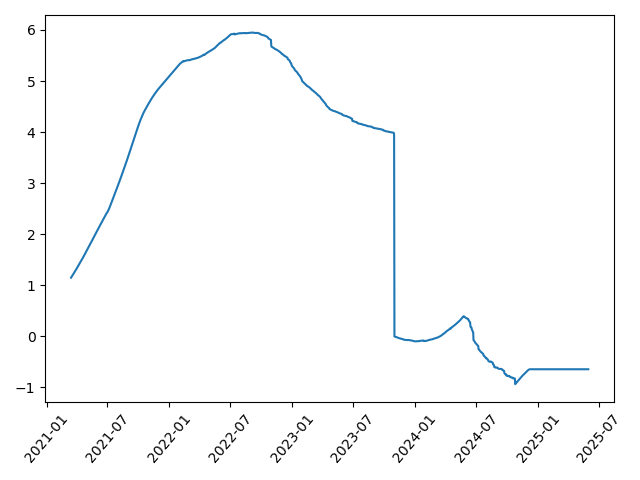

In [7]:
#filecoin_model.agents[0]['agent'].agent_info_df
agent = filecoin_model.agents[0]['agent']

plt.figure()
cc_onboarded_power_vec = []
for p in agent.onboarded_power:
    cc_onboarded_power_vec.append(p[0].pib)
plt.plot(agent.t, (agent.agent_info_df['cum_cc_onboarded'] + agent.agent_info_df['cum_cc_renewed'] -agent.agent_info_df['cum_cc_sched_expire'] - agent.agent_info_df['cum_cc_terminated'])/1024.0)
# plt.plot(agent.t, cc_onboarded_power_vec)
plt.xticks(rotation=50)

plt.tight_layout()

143.0 1172.600000000003 143.0


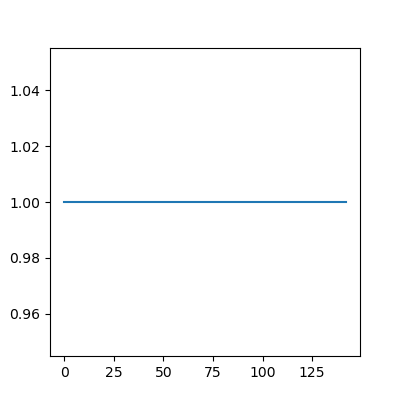

In [8]:
# print(simulation_start_date, end_date)
# agent._trace_onboarded_power(simulation_start_date, date(2025, 6, 1))

# sanity check that we trace modeled power properly
cd = simulation_start_date
rb_active_pwr_total, qa_active_pwr_total = 0, 0
rb_active_pwr_vec = []
qa_active_pwr_vec = []
days_offset = 10
while cd < (terminate_date - timedelta(days=days_offset)):
    rb_active_pwr, qa_active_pwr, _, _, _ = agent._trace_modeled_power(cd, terminate_date-timedelta(days=days_offset))
    rb_active_pwr_total += rb_active_pwr
    qa_active_pwr_total += qa_active_pwr
    
    rb_active_pwr_vec.append(rb_active_pwr)
    qa_active_pwr_vec.append(qa_active_pwr)
    
    cd += timedelta(days=1)
num_days_active = (terminate_date - simulation_start_date).days - days_offset
print(rb_active_pwr_total, qa_active_pwr_total, mean_pow*num_days_active)

plt.figure(figsize=(4,4))
plt.plot(rb_active_pwr_vec)

In [9]:
forecasts_df = filecoin_model.global_forecast_df
update_dates = filecoin_model.minting_process.update_dates
model_df = filecoin_model.filecoin_df
model_df_simsubset = model_df[model_df['date'] >= pd.to_datetime(simulation_start_date)]

/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_31160/1742197849.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  model_df_simsubset = model_df[model_df['date'] >= pd.to_datetime(simulation_start_date)]


In [10]:
model_df

,date,days,network_baseline,cum_simple_reward,total_vest,burn_from_terminations,day_pledge_per_QAP,day_rewards_per_sector,discount_rate_pct,pledge_delta,...,disbursed_reserve,network_gas_burn,day_locked_pledge,day_renewed_pledge,network_locked_pledge,network_locked_reward,original_pledge,renewal_rate,network_locked,circ_supply
0,2021-03-15,151,4.248358e+18,1.540053e+07,1.093991e+08,0,0.000000,0.000000,0.0,0.000000,...,1.706662e+07,1.906991e+07,0.000000,0.0,2.436798e+07,2.436798e+07,0.0,0.0,4.873596e+07,1.006087e+08
1,2021-03-16,152,4.256434e+18,1.550008e+07,1.100472e+08,0,0.309908,0.003313,0.0,312544.429188,...,1.706662e+07,1.916571e+07,312554.429188,0.0,2.468053e+07,2.451128e+07,0.0,0.0,4.919181e+07,9.835867e+07
2,2021-03-17,153,4.264525e+18,1.559961e+07,1.106954e+08,0,0.303714,0.003298,0.0,317022.046549,...,1.706662e+07,1.919340e+07,317023.246764,0.0,2.499755e+07,2.465514e+07,0.0,0.0,4.965269e+07,9.889161e+07
3,2021-03-18,154,4.272631e+18,1.569910e+07,1.113435e+08,0,0.304259,0.003284,0.0,313696.085079,...,1.706662e+07,1.925624e+07,313696.448024,0.0,2.531124e+07,2.479951e+07,0.0,0.0,5.011075e+07,9.939397e+07
4,2021-03-19,155,4.280752e+18,1.579857e+07,1.119917e+08,0,0.304729,0.003270,0.0,314080.785938,...,1.706662e+07,1.930788e+07,314081.145504,0.0,2.562533e+07,2.494437e+07,0.0,0.0,5.056969e+07,9.990837e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533,2025-05-26,1684,7.808132e+19,1.363413e+08,5.055742e+08,0,0.000000,0.004746,25.0,0.000000,...,1.706662e+07,5.302131e+07,0.000000,0.0,-1.785467e+07,1.031809e+07,0.0,0.0,-7.536582e+06,8.418573e+08
1534,2025-05-27,1685,7.822974e+19,1.364026e+08,5.057613e+08,0,0.000000,0.004744,25.0,0.000000,...,1.706662e+07,5.304346e+07,0.000000,0.0,-1.785467e+07,1.031215e+07,0.0,0.0,-7.542521e+06,8.420967e+08
1535,2025-05-28,1686,7.837844e+19,1.364639e+08,5.059484e+08,0,0.000000,0.004743,25.0,0.000000,...,1.706662e+07,5.306561e+07,0.000000,0.0,-1.785467e+07,1.030623e+07,0.0,0.0,-7.548441e+06,8.423361e+08
1536,2025-05-29,1687,7.852742e+19,1.365251e+08,5.061355e+08,0,0.000000,0.004741,25.0,0.000000,...,1.706662e+07,5.308775e+07,0.000000,0.0,-1.785467e+07,1.030033e+07,0.0,0.0,-7.554343e+06,8.425755e+08


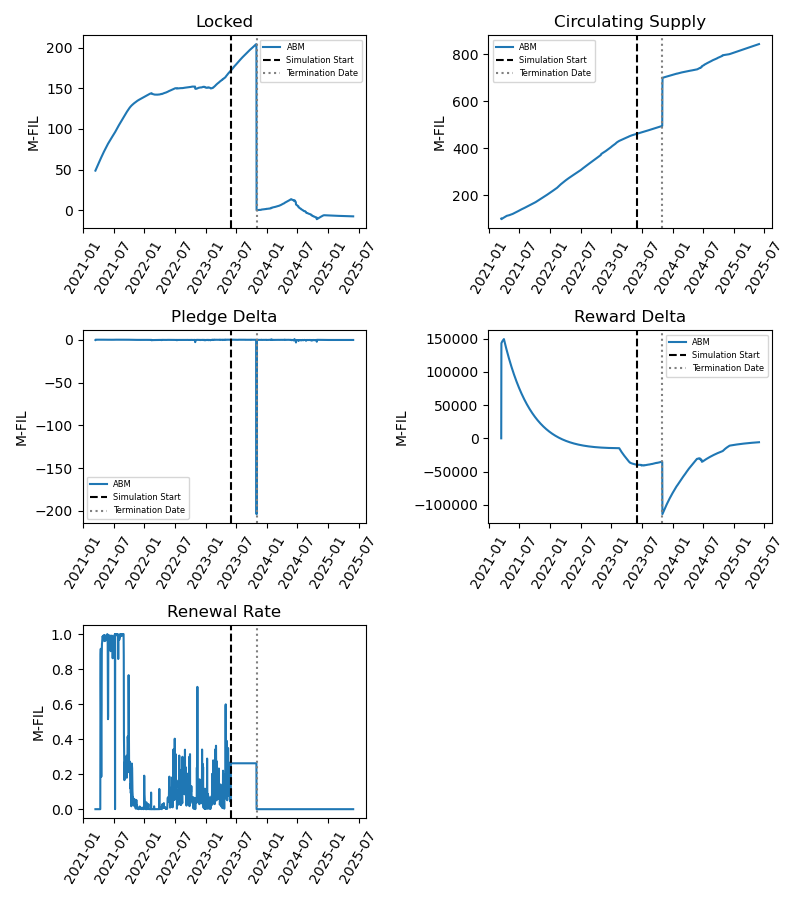

In [11]:
plt.figure(figsize=(8,9))

plt.subplot(3,2,1)
plt.plot(model_df['date'], model_df['network_locked']/1_000_000, label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Locked')
plt.legend(fontsize=6)

plt.subplot(3,2,2)
plt.plot(model_df['date'], model_df['circ_supply']/1_000_000, label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.legend(fontsize=6)

plt.subplot(3,2,3)
plt.plot(model_df['date'], model_df['pledge_delta']/1e6, label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Pledge Delta')
plt.legend(fontsize=6)

plt.subplot(3,2,4)
plt.plot(model_df['date'], model_df['reward_delta'], label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Reward Delta')
plt.legend(fontsize=6)

plt.subplot(3,2,5)
plt.plot(model_df['date'], model_df['renewal_rate'], label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Renewal Rate')

plt.tight_layout()

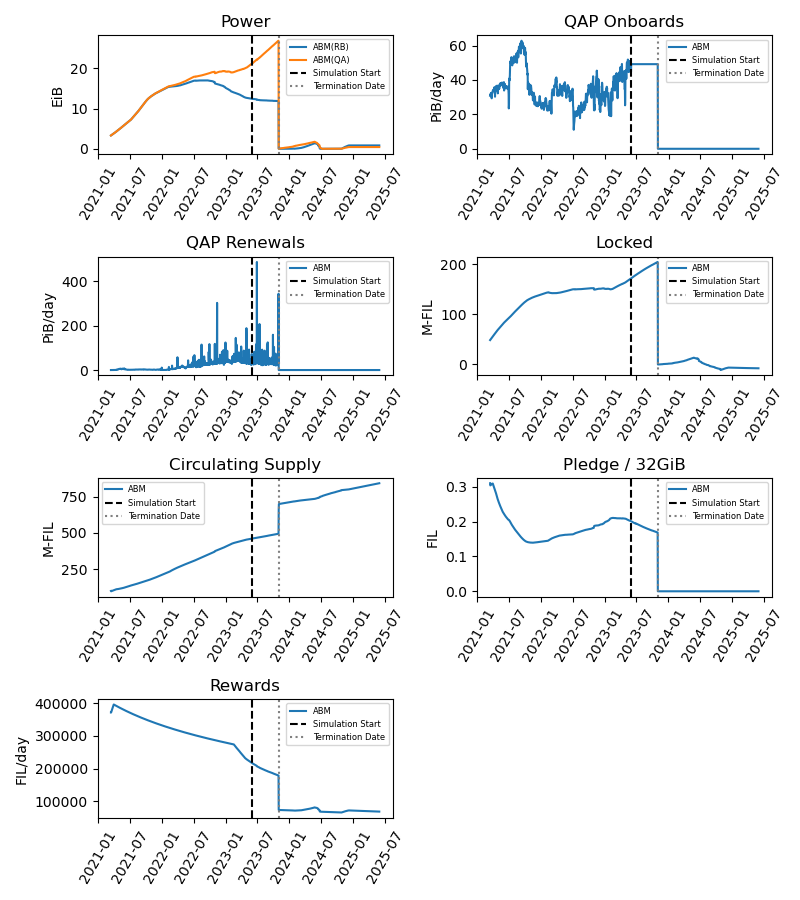

In [12]:
plt.figure(figsize=(8,9))
plt.subplot(4,2,1)
plt.plot(model_df['date'], model_df['total_raw_power_eib'], label='ABM(RB)')
plt.plot(model_df['date'], model_df['total_qa_power_eib'], label='ABM(QA)')
# plt.plot(model_df['date'], model_df['network_baseline'] / 2**60, label='Baseline')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.legend(fontsize=6)
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('Power')

plt.subplot(4,2,2)
plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'], label='ABM')
# plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'] - mechafil_df['day_onboarded_power_QAP']/PIB, 
#          label='Onboarded[ABM-MechaFIL]')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.xticks(rotation=60)
plt.title('QAP Onboards')
plt.ylabel('PiB/day')
plt.legend(fontsize=6)

plt.subplot(4,2,3)
plt.plot(model_df['date'], model_df['day_renewed_qap_pib'], label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.xticks(rotation=60)
plt.title('QAP Renewals')
plt.ylabel('PiB/day')
plt.legend(fontsize=6)

plt.subplot(4,2,4)
plt.plot(model_df['date'], model_df['network_locked']/1_000_000, label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Locked')
plt.legend(fontsize=6)

plt.subplot(4,2,5)
plt.plot(model_df['date'], model_df['circ_supply']/1_000_000, label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.legend(fontsize=6)

plt.subplot(4,2,6)
plt.plot(model_df['date'].iloc[1:], model_df['day_pledge_per_QAP'].iloc[1:], label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('FIL')
plt.xticks(rotation=60)
plt.title('Pledge / 32GiB')
plt.legend(fontsize=6)

plt.subplot(4,2,7)
plt.plot(model_df['date'], model_df['day_network_reward'], label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('FIL/day')
plt.xticks(rotation=60)
plt.title('Rewards')
plt.legend(fontsize=6)

plt.tight_layout()

plt.show()
plt.savefig(os.path.join(os.environ['HOME'], 'Documents', 'hackmd', 'abm', 'terminate.png'))